# High-dimensional Filtering on a Gaussian linear model

In [1]:
library(MASS) # for multivariate Gaussian simulation : function mvrnorm
library(RSQMC) # homemade Rcpp package for internal filter functions
library(profvis) # R profiler
library(parallel) # parallel computing for backward simulations

library(ggplot2) # plotting library

# homemade functions
source("/Users/Schreuder/Google Drive/ENSAE/2A/Stage2A/bRistol/Example1Functions.R") 

# for reproducibility
set.seed(41)

### Parameters

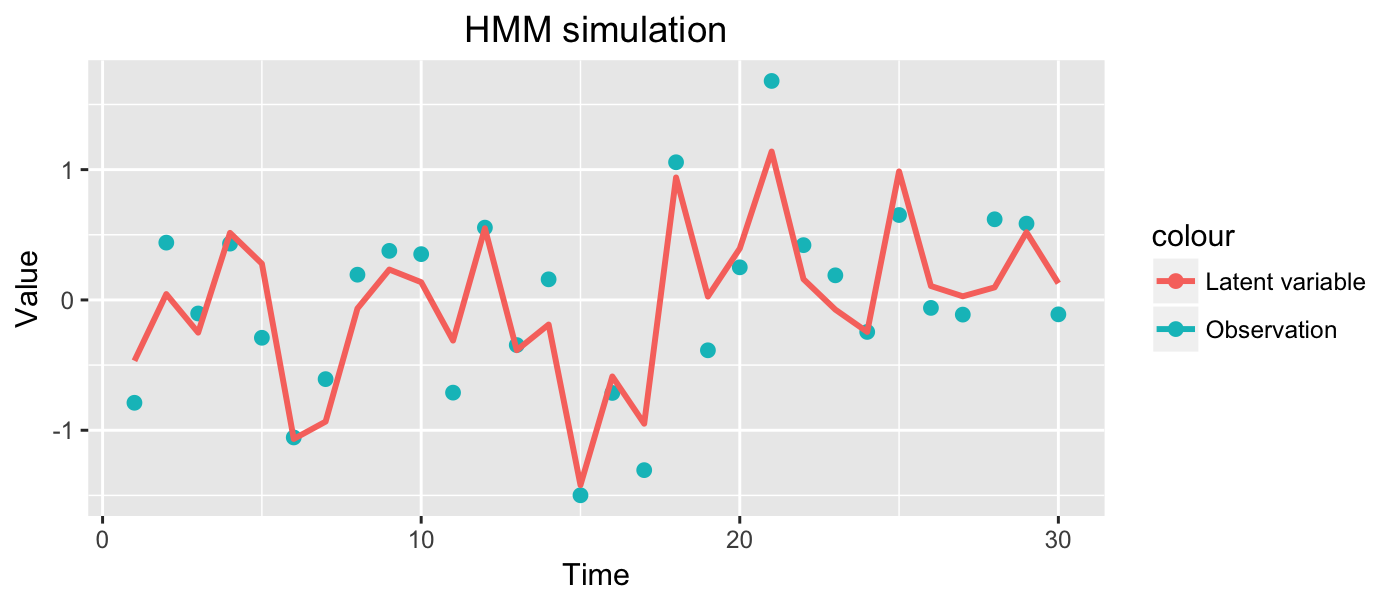

In [2]:
T_ <- 30 # time
D <- 2 # dimension of x
sigma_y <- .25**2 # variance of y|x
M <- 64 # number of internal particles
N <- 100 # number of external particles
tau <- 1. # coordinates variance
lambda <- 1. # coordinates correlation
nb_filters <- 2 # number of external filters 

## Covariance matrix 
S = covariance_matrix(D, tau, lambda)

# State-space model
SSM = state_space_model(D, T_, S, sigma_y)
x = SSM$X
y = SSM$Y

df = data.frame(x = x[1, ], y= y[1,])
df$idu <- as.numeric(row.names(df))
options(repr.plot.height=3, repr.plot.res = 200)
(ggplot(df) + geom_point(aes(x=idu, y=y, color='Observation'), size=2)+ 
 geom_line(aes(x=idu, y=x, color='Latent variable'), size=1) + 
 xlab('Time') + ylab('Value') + labs(title='HMM simulation') + 
 theme(plot.title = element_text(hjust = 0.5)) )

# SMC proposal comparison

We run two particle filters : a "naive" particle filter (by taking as proposal the transition kernel : bootstrap PF) and a "guided" particle filter (by taking into account the observation in the proposal) to show that SMC struggle in high dimension without a good proposal.

In [3]:
library(mvtnorm) # for multivariate Gaussian density
number_of_particles <- N*M # for fair comparison between SMC and NSMC

In [4]:
## Bootstrap particle filter ##
pred_naive <- array(0, dim=c(D, T_))
pred_naive <- gaussian_bootstrap_filter(y, sigma_y, D, T_, S, number_of_particles)

## Guided particle filter (optimal proposal) ##
pred_optimal <- array(0, dim=c(D, T_))
pred_optimal <- gaussian_guided_filter(y, sigma_y, D, T_, S, number_of_particles)

plot_coordinate = 1

df_proposal_comparison = data.frame(real_value = x[plot_coordinate, ], 
                                    naive = pred_naive[plot_coordinate, ], 
                                    optimal = pred_optimal[plot_coordinate, ])


plot_title =  bquote(Estimation ~ of ~ one ~ coordinate ~ of ~ the ~ latent ~ variable ~"("*n[x] == .(D)*")")
plot_proposal_comparison <- (ggplot(df_proposal_comparison) + 
               geom_line(aes(x=1:T_, y=real_value, colour='Real value'), size=0.8) + 
               geom_line(aes(x=1:T_, y=optimal, colour='Optimal proposal'), size=0.5) + 
               geom_line(aes(x=1:T_, y=naive, colour='Bootstrap proposal'), size=0.5) +
                             labs(color="")+
               xlab('Time') + ylab('Value'))

savename <- paste('plots/proposal_comparison/', D,'_', N, '_', M, '.pdf', sep="")
ggsave(filename=savename, plot=plot_proposal_comparison, height=5,width=7,dpi=72)

plot_proposal_comparison  + labs(title=plot_title)

ERROR: Error in W[, T_]: subscript out of bounds


## NSMC

We compare Nested Sequential Monte Carlo as described in $\textit{High-dimensional Filtering using Nested Sequential Monte Carlo}$ by $\textit{Naesseth & al.}$ on a simple Gaussian linear model with and without QMC.

NSMC is designed to perform Sequential Monte Carlo on particular high dimensional models in which the optimal proposal is not necessarly tractable. 

It exploits the local dependencies of the state-space variable to simulate exact approximation of the optimal proposal.

We run each filter several times to compute empirical variance of the resulting estimators.

### NSMC without QMC

In [ ]:
MAP_without_QMC <- array(0, dim=c(nb_filters, D, T_))

particles <- array(0, dim=c(N, D, T_+1))
weights <- array(0, N)
log_likelihood <- array(0, N)
internal_weights <- array(0, dim=c(T_+1, M, D, N))
internal_particles <- array(0, dim=c(T_+1, M, D, N))

for(f in 1:nb_filters){
    
  # External particles initialisation 
  particles[, , 1] <- mvrnorm(n = N, matrix(0, D), S)
  
  for(t in 2:(T_+1)){
      
    # The internal filter returns :
    # - the log-likelihood of the SMC along the coordinates (= weights for resampling) 
    # - the generated internal particles (needed for backward simulation)
    # - the associated internal weights (needed for backward simulation)
    # NB : the particles start at time t=2 and the observations y at t=1 
    internal_filter_output = internal_filter(N, y[, t-1], M, D, S, 
                                             particles[, , t-1], sigma_y)
    internal_weights[t, , , ] <- internal_filter_output$Weights
    internal_particles[t, , ,] <- internal_filter_output$Particles
    log_likelihood <- internal_filter_output$Log_Likelihood
  
    # Weights normalisation
    weights = exp(log_likelihood - max(log_likelihood))
    sum = sum(weights)
    weights = weights/sum

    # Resampling step
    resampling = sample(N, replace = T, prob = weights)
    
    # Backward simulation (parallelised)
    cl <- makeCluster(3)
    particles[, , t] <- t(parSapply(cl, 1:N, backward_paralell, resampling=resampling, 
                                    N=N, M=M, t=t, D=D, weights=weights, particles=particles, 
                                    internal_particles=internal_particles, 
                                    internal_weights=internal_weights, S=S))
    stopCluster(cl)
  }
  MAP_without_QMC[f, , ] <- apply(particles[ , , 2:(T_+1)], c(2,3), mean)
}

### NSMC with QMC

In [10]:
MAP_with_QMC <- array(0, dim=c(nb_filters, D, T_))

particles <- array(0, dim=c(N, D, T_+1))
weights <- matrix(0, N)
log_likelihood <- matrix(0, N)
internal_weights <- array(0, dim=c(T_+1, M, D, N))
internal_particles <- array(0, dim=c(T_+1, M, D, N))

for(f in 1:nb_filters){  
  # Initialise particles
  particles[, , 1] <- mvrnorm(n = N, matrix(0, D), S)
  
  for(t in 2:(T_+1)){
      
    # The internal filter returns :
    # - the log-likelihood (= weights for resampling) 
    # - the generated internal particles (needed for backward simulation)
    # - the associated internal weights (needed for backward simulation)
    # NB : the particles start at time t=2 and the observations y at t=1 
    internal_filter_output = internal_filter_with_QMC(N, y[, t-1], M, 
                                                      D, S, particles[, , t-1], sigma_y)
    internal_weights[t, , , ] <- internal_filter_output$Weights
    internal_particles[t, , ,] <- internal_filter_output$Particles
    log_likelihood <- internal_filter_output$Log_Likelihood
    
    # Weights normalisation
    weights = exp(log_likelihood - max(log_likelihood))
    sum = sum(weights)
    weights = weights/sum
    
    # Resampling step
    resampling = sample(N, replace = T, prob = weights)
    
    # Backward simulation (parallelised)
    cl <- makeCluster(3)
    particles[, , t] <- t(parSapply(cl, 1:N, backward_paralell, 
                                    resampling=resampling, N=N, M=M, t=t, D=D, 
                                    weights=weights, particles=particles, 
                                    internal_particles=internal_particles, 
                                    internal_weights=internal_weights, S=S))
    stopCluster(cl)
  }
  MAP_with_QMC[f, , ] <- apply(particles[ , , 2:(T_+1)], c(2,3), mean)
}

### Comparison

#### Latent variable estimation

In [9]:
plot_coordinate = 1
df = data.frame(real_value = x[plot_coordinate, ], 
                no_QMC = MAP_without_QMC[1, plot_coordinate, ], 
                QMC = MAP_with_QMC[1, plot_coordinate, ])

df$idu <- as.numeric(row.names(df))

prediction_plot <- (ggplot(df) + geom_point(aes(x=idu, y=real_value, color='Real value')) + 
 geom_line(aes(x=idu, y=no_QMC, color='Without QMC')) + 
 geom_line(aes(x=idu, y=QMC, color='With QMC'))+ 
 labs(title='Prediction') + 
 xlab('Time') + ylab('Value') +
 theme(plot.title = element_text(hjust = 0.5)))

savename <- paste('plots/prediction_comparison/prediction_plot_', D,'_', N, '_', M, '.pdf', sep="")
ggsave(filename=savename, plot=prediction_plot, height=5,width=12,dpi=72)

prediction_plot

ERROR: Error in data.frame(real_value = x[plot_coordinate, ], no_QMC = MAP_without_QMC[1, : object 'MAP_with_QMC' not found


#### Variance

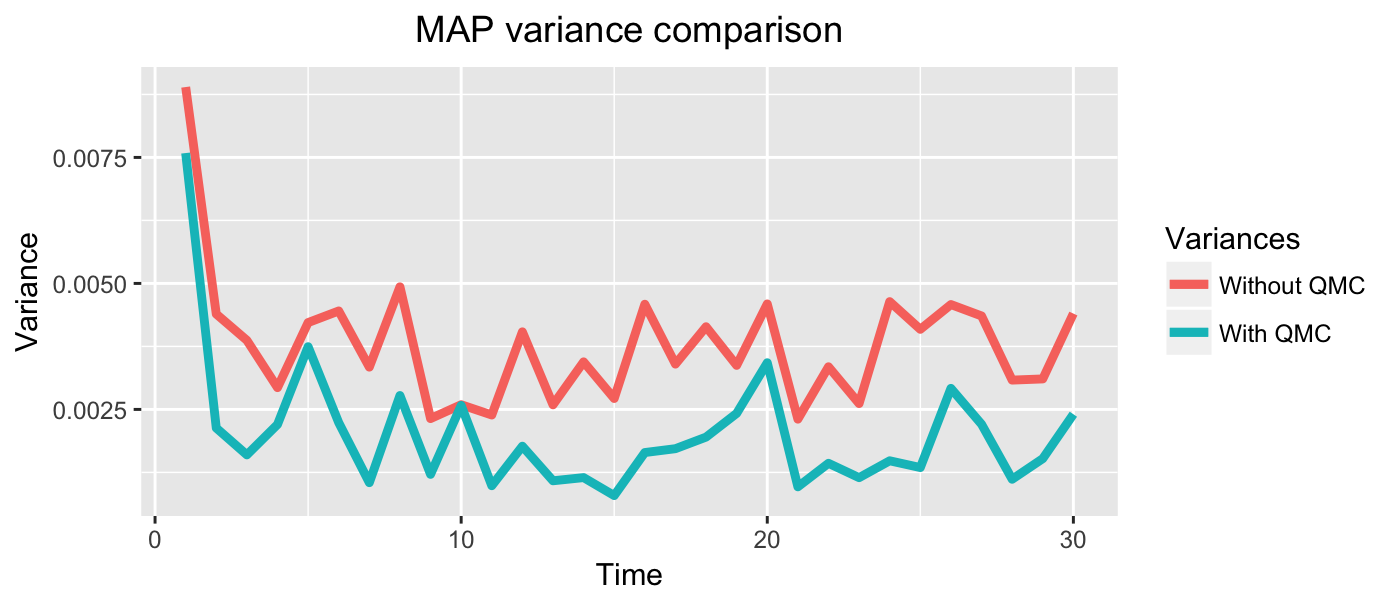

In [12]:
var = apply(MAP_without_QMC[ , , ], c(2, 3), var)
mean_var= apply(var , 2, mean)

var_QMC = apply(MAP_with_QMC[ , ,], c(2, 3), var)
mean_var_QMC = apply(var_QMC , 2, mean)

var_ratio = data.frame(variance_ratio = apply(var_QMC/mean_var_QMC, 2, mean))

#ggplot(var_ratio) + geom_line(aes(x=1:T_, y=variance_ratio), colour='blue') + geom_hline(yintercept = 1)

vars = data.frame(var = apply(var, 2, mean), var_QMC = apply(var_QMC, 2, mean))

variance_plot <- (ggplot(vars) + geom_line(aes(x=1:T_, y=var, colour='blue'), size=1.5) + 
 geom_line(aes(x=1:T_, y=var_QMC, colour='green'), size=1.5) + 
 labs(title='MAP variance comparison') +
 scale_color_discrete(name = "Variances", labels = c("Without QMC", "With QMC")) +
 xlab('Time') + ylab('Variance') + 
 theme(plot.title = element_text(hjust = 0.5)))

savename <- paste('plots/variance_comparison/variance_comparison_', D,'_', N, '_', M, '.pdf', sep="")
ggsave(filename=savename, plot=variance_plot, height=9,width=12,dpi=72)
variance_plot